Cosmo MCMC is landing on biased HOD + Cosmology. I'm gonna first look at the code to make preds, and compare to the emulator. 

In [69]:
from pearce.emulator import OriginalRecipe, ExtraCrispy, SpicyBuffalo
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [70]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [71]:
training_file = '/scratch/users/swmclau2/xi_gm_cosmo/PearceRedMagicXiGMCosmoFixedNd.hdf5'
#training_file = '/u/ki/swmclau2/des/PearceRedMagicXiCosmoFixedNdLowMsat.hdf5'
test_file = '/scratch/users/swmclau2/xi_gm_cosmo_test/PearceRedMagicXiGMCosmoFixedNdTest.hdf5'
#test_file = '/u/ki/swmclau2/des/PearceRedMagicXiCosmoFixedNdLowMsatTest.hdf5'

#test_file = '/u/ki/swmclau2/des/xi_cosmo_tester/PearceRedMagicXiCosmoFixedNd_test.hdf5'
em_method = 'gp'
split_method = 'random'

In [72]:
a = 1.0
z = 1.0/a - 1.0

In [73]:
fixed_params = {'z':z}#, 'cosmo': 3}#, 'r':0.53882047}

In [74]:
np.random.seed(0)
emu = SpicyBuffalo(training_file, method = em_method, fixed_params=fixed_params,
                 custom_mean_function = 'linear', downsample_factor = 0.1)

In [75]:
#hod_param_names = ['logM0', 'sigma_logM', 'logM1', 'alpha']
emulation_point = [('logM0', 13.5), ('sigma_logM', 0.25),
                    ('alpha', 0.9),('logM1', 13.5)]#, ('logMmin', 12.233)]

#em_params = {key:test_point_dict[key] for key in hod_param_names}
#em_params = dict(zip(hod_param_names, x_point))
em_params = dict(emulation_point)
em_params.update(fixed_params)

In [76]:
r_bins = np.logspace(-1.1, 1.6, 19)
rpoints = (r_bins[1:]+r_bins[:-1])/2.0

In [77]:
fixed_params = {}#'f_c':1.0}#,'logM1': 13.8 }# 'z':0.0}

cosmo_params = {'simname':'testbox', 'boxno': 0, 'realization': 1, 'scale_factors':[1.0], 'system': 'sherlock'}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

In [78]:
# get cosmo params
try:
    del em_params['logMmin']
except KeyError:
    pass
cpv = cat._get_cosmo_param_names_vals()

cosmo_param_dict = {key: val for key, val in zip(cpv[0], cpv[1])}

em_params.update( cosmo_param_dict)


In [79]:
y_emu = 10**emu.emulate_wrt_r(em_params)[0]

In [80]:
boxno, realization = 0,1

In [81]:
y_calc_jk = np.loadtxt('/home/users/swmclau2/Git/pearce/bin/mcmc/xi_gm_true_jk_%d%d.npy'%(boxno, realization))
y_calc_mean = np.loadtxt('/home/users/swmclau2/Git/pearce/bin/mcmc/xi_gm_true_mean_%d%d.npy'%(boxno, realization))
y_cov_jk = np.loadtxt('/home/users/swmclau2/Git/pearce/bin/mcmc/xi_gm_cov_true_jk_01.npy')

In [82]:
scov = np.loadtxt('/home/users/swmclau2/Git/pearce/bin/mcmc/xigm_scov.npy')

In [83]:
cov = y_cov_jk + scov
y_err = np.sqrt(np.diag(cov))

In [101]:
y_err

array([  4.17182343e+02,   1.86599755e+02,   1.09549310e+02,
         5.27128895e+01,   2.86241289e+01,   1.66178906e+01,
         9.06873349e+00,   5.32693510e+00,   2.62137244e+00,
         1.25217711e+00,   5.19070648e-01,   1.83866929e-01,
         5.62819307e-02,   3.11728128e-02,   1.88569378e-02,
         9.50845838e-03,   5.00869591e-03,   4.12958166e-03])

In [84]:
fname = '/scratch/users/swmclau2/PearceMCMC/500_walkers_20000_steps_xi_gg_gm_m0_1_rmin_emu2.npy'

In [85]:
from itertools import islice
def load_chain(fname, n_walkers, n_burn):
    chain_list = []
    with open(fname, 'r') as f:
        step_counter = 0
        pnames_line =  f.readline() #header
        pnames = pnames_line[1:].split()
        while True:
            next_lines = islice(f, n_walkers)
            step_counter+=1

            if step_counter % 100 == 0:
                #print step_counter, len(chain_list)
                pass

            if step_counter < n_burn:# or step_counter > 20000:
                for line in next_lines:
                    pass
                continue

            next_lines = np.array([ np.fromstring(line, sep = ' ') for line in next_lines], dtype=float)

            if len(next_lines) < 1:
                break

            chain_list.append(next_lines)
    return np.vstack(chain_list), pnames

In [86]:
n_walkers, n_burn = 500, 18000
chain, param_names = load_chain(fname, n_walkers, n_burn)

In [87]:
print chain.shape, chain.shape[0]/n_walkers

(1000500, 7) 2001


In [88]:
MAP = chain.mean(axis = 0)
print MAP

[  3.02686018e+00   6.47820041e+01  -8.03009543e-01   1.17053219e-01
   3.10115275e+00   9.77711819e-01   2.25434747e-02]


In [89]:
param_names = ['Neff', 'H0', 'w0', 'omch2', 'ln10As',  'ns',  'ombh2']                                             

In [90]:
varied_param_name = 'H0'
bounds = emu.get_param_bounds(varied_param_name)
Nvp = 100
vp_vals = np.linspace(bounds[0], bounds[1], Nvp)

varied_param_xis = []
for val in vp_vals:
    em_params[varied_param_name] = val
    varied_param_xis.append(10**emu.emulate_wrt_r(em_params))

In [91]:
em_params.update(dict(zip(param_names, MAP)))
MAP_xi = 10**emu.emulate_wrt_r(em_params)[0]

In [102]:
chain_vals = []
_chain = chain[chain[:,2]<-1]
rand_idxs = np.random.choice(_chain.shape[0], size = 2000, replace = False)
rand_chain = _chain[rand_idxs]

for row in rand_chain:
    cosmo_params = dict(zip(param_names, row))
    #cosmo_params['Neff'] = cosmo_param_dict['Neff']
    #cosmo_params['ln10As'] = cosmo_param_dict['ln10As']
    em_params.update(cosmo_params)

    chain_vals.append(10**emu.emulate_wrt_r(em_params))

In [103]:
vp_palette = sns.cubehelix_palette(Nvp)

In [104]:
cpv[1]

array([  2.32629000e-02,   1.07830000e-01,  -7.26513000e-01,
         9.80515000e-01,   3.03895000e+00,   6.32317000e+01,
         2.95000000e+00])

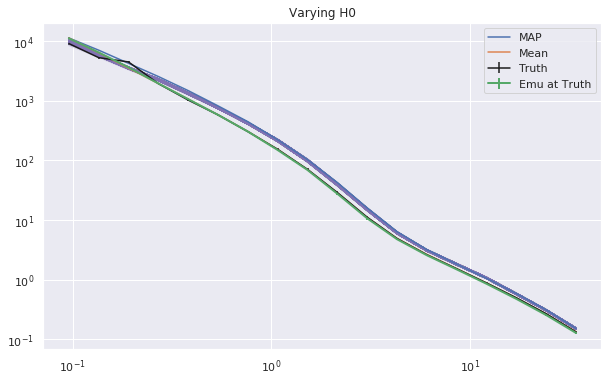

In [105]:
fig = plt.figure(figsize = (10,6))

for val in chain_vals:
    plt.plot(rpoints, val[0], c= 'm', alpha = 0.1 )
    
#for i, (val, pval) in enumerate(zip(varied_param_xis, vp_vals)):
#    plt.plot(rpoints, val[0], color = vp_palette[i], alpha = 0.8)
    

plt.plot(rpoints, MAP_xi, label = 'MAP')
    
plt.errorbar(rpoints, y_calc_jk, yerr= y_err,  c = 'k', label = 'Truth')
plt.plot(rpoints, y_calc_mean  , label = 'Mean')
plt.errorbar(rpoints, y_emu, yerr = y_err ,c = 'g',lw =2, label = 'Emu at Truth')
#plt.xscale('log')
plt.loglog()
plt.title('Varying %s'%varied_param_name)
plt.legend(loc = 'best')
plt.show()

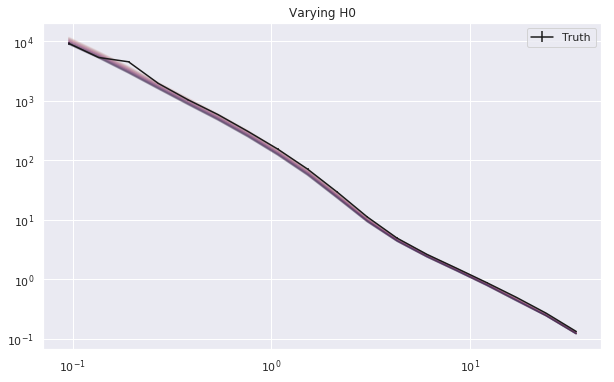

In [96]:
fig = plt.figure(figsize = (10,6))

#for val in chain_vals:
#    plt.plot(rpoints, val[0]-y_calc_jk, c= 'm', alpha = 0.1 )
    
for i, (val, pval) in enumerate(zip(varied_param_xis, vp_vals)):
    plt.plot(rpoints, val[0], color = vp_palette[i], alpha = 0.05)
    

#plt.plot(rpoints, MAP_xi, label = 'MAP')
    
plt.errorbar(rpoints, y_calc_jk, yerr= y_err,  c = 'k', label = 'Truth')
#plt.plot(rpoints, y_calc_mean  , label = 'Mean')

#plt.plot(rpoints, y_emu, c = 'g',lw =2, label = 'Emu at Truth')
#plt.xscale('log')
plt.loglog()
plt.title('Varying %s'%varied_param_name)
plt.legend(loc = 'best')
plt.show()

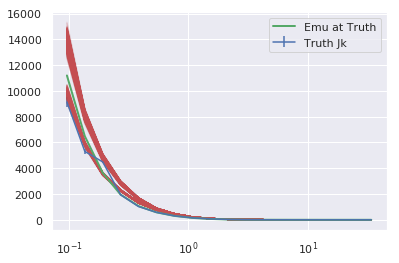

In [97]:
for val in chain_vals:
    plt.plot(rpoints, val[0], c= 'r', alpha = 0.1 )
    
#plt.errorbar(rpoints, y_calc, yerr= y_err,  c = 'k', label = 'Truth')
plt.errorbar(rpoints, y_calc_jk, yerr= y_err_jk,  c = 'b', label = 'Truth Jk')
plt.plot(rpoints, y_emu, c = 'g',lw =2, label = 'Emu at Truth')

plt.xscale('log')
#plt.loglog()
plt.legend(loc = 'best')
plt.show()

NameError: name 'y_calc' is not defined

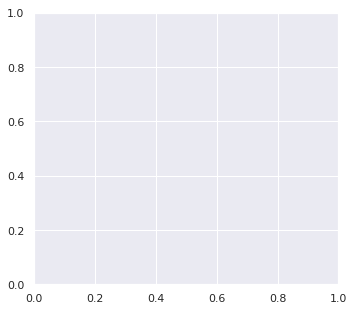

In [98]:
fig = plt.figure(figsize = (12, 5))

plt.subplot(121)
#plt.plot(rpoints, y_calc, label = 'Sim')
plt.plot(rpoints, y_calc, label = 'Sim')
plt.plot(rpoints, y_pred, label = 'Emu')
plt.xscale('log')
plt.legend(loc = 'best')
plt.ylabel(r'$\xi_{gg}(r)$')
plt.xlabel(r'$r$ [Mpc]')
plt.subplot(122)
#plt.plot(rpoints, y_calc/y_point, label = 'Sim')
plt.plot(rpoints, y_pred/y_calc, label = 'Emu/Sim')
plt.legend(loc = 'best')
plt.xlabel(r'$r$ [Mpc]')

plt.xscale('log')
plt.show()

In [ ]:
print y_pred/y_calc

In [ ]:
fixed_params = {'z':z, 'cosmo': 3}#, 'r':0.53882047}
train_x, train_y, _, info = emu.get_data(test_file, fixed_params, None)#, skip_nans = False)

In [ ]:
info

In [ ]:
cpv = cat._get_cosmo_param_names_vals()
cosmo_params = dict(zip(cpv[0], cpv[1]))

In [ ]:
for idx in xrange(100):
    x_point = train_x[idx*emu.n_bins, :-1]
    y_point = train_y[idx*emu.n_bins:(idx+1)*emu.n_bins]
    pop_params = dict(zip(info['ordered_params'].keys(), x_point))

    
    #add_logMmin(pop_params, cat)
    print pop_params

    #_xi_vals = []
    #for i in xrange(10):
    #    cat.populate(pop_params, min_ptcl=100)
    #    _xi_vals.append(cat.calc_xi(r_bins))

    #xi_vals = np.log10(np.array(_xi_vals))
    #y_calc = xi_vals.mean(axis = 0)
    
    pop_params.update(cosmo_params)
    #del pop_params['logMmin']
    
    y_pred = emu.emulate_wrt_r(pop_params)[0]

    fig = plt.figure(figsize = (14, 6))

    plt.subplot(121)
    #plt.plot(rpoints, y_calc, label = 'Sim')
    plt.plot(rpoints, y_point, label = 'Data')
    plt.plot(rpoints, y_pred, label = 'Emu')
    plt.xscale('log')
    plt.legend(loc = 'best')
    plt.subplot(122)
    #plt.plot(rpoints, y_calc/y_point, label = 'Sim')
    plt.plot(rpoints, y_pred/y_point, label = 'Emu/True')
    plt.legend(loc = 'best')

    plt.xscale('log')
    plt.show()